First we will extract claims from a patent, to use for exploring different models and methods for clustering:
Note: Not all claims are the same length, some of them are more like paragraphs then a sentence and I'll need to keep that in mind when choosing the right model and method for clustering.

In [766]:
import moveoHLS_task
site = "https://patents.google.com/patent/GB2478972A/en?q=(phone)&oq=phone"
claims = []
soup = moveoHLS_task.get_soup_from_url(site)
moveoHLS_task.extract_claim_texts(soup, claims)

Total claims found: 14
All claim texts extracted successfully.


In general, the clustering task can be split into two parts: encoding the claims and clustering them.

Encoders:
I experimented with TF-IDF, transformers, BERT,GloVe Word2Vec encoders. 
In this notebook I present the results of the clustering using TF-IDF, transformers, as BERT and GLoVe didn't yield better results.

Clustering Methods:
I experimented with k-means, Hierarchical clustering and DBSCAN.
In this notebook I present the results of the clustering using k-means and Hierarchical clustering. DBSCAN didn't yield better results.

The assignment instructions limited the number of experiments with different models and methods, so I didn't present everything I experimented with.


First, we will encode the claims using TF-IDF and transformers:


In [767]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans 
import pandas as pd

df = pd.DataFrame(claims, columns=['Strings'])

documents = df['Strings'].values.astype("U")

vectorizer = TfidfVectorizer(stop_words='english')
features_tfidf = vectorizer.fit_transform(documents).toarray()
df['encode_tf-idf'] = list(features_tfidf)
#print(features_tfidf.shape)

In [768]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer('all-MiniLM-L6-v2')
df['encode_transformer'] = df['Strings'].apply(lambda text: model.encode(text, convert_to_numpy=True).flatten())
features_transformers = np.vstack(df['encode_transformer'])
#print(features_transformers.shape)

C:\Users\danba\anaconda3\envs\pythonProject5\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Some functions to help us visualize the clusters, notes in the functions description.

In [769]:
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def dimension_reduction(embedding, method):
    """
    Important Note: Visualizing the data in 2D serves as a heuristic tool to better understand the data.
    In general, textual data distributes in a way that can provide useful insights in 2D, but this is not always the case.
    The TF-IDF encoding transforms the data into an 83-dimensional space, while the transformers encode the data into a 384-dimensional space,
    and so reducing the dimensionality to 2 dimensions will cause loss of information.
    
    I also tried visualizing the data in 3D, but the results were not so clear
    and it seems like it didn't provide any additional insights over the 2D visualization.
    """
    pca = PCA(n_components=2, random_state=42)

    pca_vecs = pca.fit_transform(embedding)

    # save our two dimensions into x0 and x1
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]
    
    df[f'x0_{method}'] = x0 
    df[f'x1_{method}'] = x1
    
def plot_pca(x0_name, x1_name, cluster_name):
    """
    Plot the PCA reduced data
    """

    plt.figure(figsize=(12, 7))

    plt.title(f"{cluster_name}", fontdict={"fontsize": 18})
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})

    sns.scatterplot(data=df, x=x0_name, y=x1_name, hue=cluster_name, palette="viridis")
    
    for index, row in df.iterrows():
        plt.annotate(index, (row[x0_name], row[x1_name]), textcoords="offset points", xytext=(0,10), ha='center')
    
    plt.show()

def eval_cluster(cluster_col,encode_col,num_clusters=2):
    """
    The assignment did not provide a ground truth for the clustering,
    so I thought a good way to evaluate the models' performance could be achieved by evaluating the clusters it creates.
        
    -What is a good cluster?-
    By measuring the mean distance of the points in the same cluster from its center
    and the max distance of the points in the same cluster from its center, we can get a sense of how well the cluster is formed.
    
    Note1: the distance calculations is done in the original space, not the reduced space.
    This way we can assess how well the embedding space the encoder creates suits the data.
    
    Note2: We can not compare the distances between different encodings, as the distances are calculated in different spaces! 
    """
    #get mean distnace of points in the same cluster from the centroid
    for i in range(num_clusters):
        cluster = df[df[cluster_col] == i][encode_col]
        cluster = cluster.apply(lambda x: x.cpu().detach().numpy() if torch.is_tensor(x) else x)
        array = np.array(cluster.tolist())
        centroid = np.mean(array, axis=0)
        mean_distance = np.mean(pairwise_distances(array, centroid.reshape(1, -1)))
        print(f"Mean distance of points in cluster {i} from centroid: {mean_distance}")
        max_distance = np.max(pairwise_distances(array, centroid.reshape(1, -1)))
        print(f"Max distance of points in cluster {i} from centroid: {max_distance}")

Although in task number 3 the users could choose the number of clusters, for the exploration part I let my models perform clustering for a range of clusters.
The distances we measured to evaluate the clusters will become smaller as k increases,
but I wanted to find the right k that gives a reasonable clustering so I could evaluate the models better.

-Why work with kmeans and hierarchical clustering?-
KMeans is a simple and fast clustering algorithm that works well with high-dimensional data.
On the other hand, kmeans assumes spherical structure of tha clusters,which might not fit our case, so I decide to use also Agglomerative clustering.

C:\Users\danba\anaconda3\envs\pythonProject5\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Mean distance of points in cluster 0 from centroid: 0.8661051710337361
Max distance of points in cluster 0 from centroid: 0.9425404831641673
Mean distance of points in cluster 1 from centroid: 0.8329768479353955
Max distance of points in cluster 1 from centroid: 0.8816082436224332


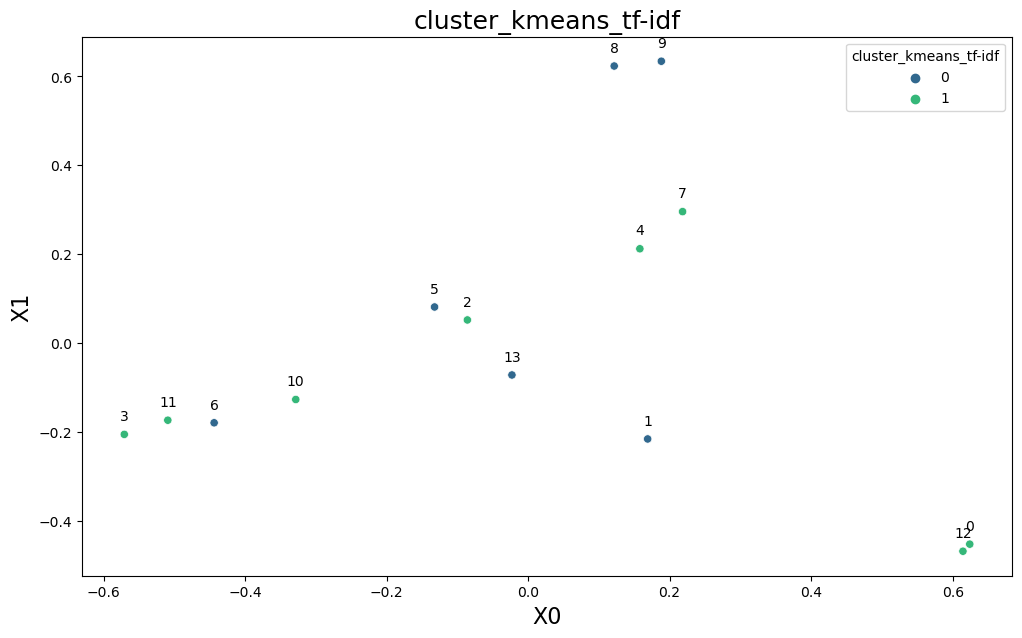

Group 0:
The apparatus of claim 1, ftirther comprising a body having a cradle for the handset, wherein the onloff hook switch operates in response to placing the handset in the cradle.

The apparatus of any one of claims 3 to 5, further comprising means for enabling a phonebook lookup operation when in the call initiation mode.

The apparatus of any one of claims 3 to 6, wherein the call initiation mode and a dialling mode are entered using the first predetermined button.

The apparatus of claim 8, further comprising selection means for selecting information displayed on the display means.

The apparatus of claim 8 or 9, wherein the transfer means is adapted to initiate a call to a second party whose information is displayed on the display means.

A communication apparatus as substantially herein before described with reference to the accompanying drawings in Figures 1 to 7.

Group 1:
A wireless telephone apparatus comprising: a handset; an onioff-hook switch; a wireless communications

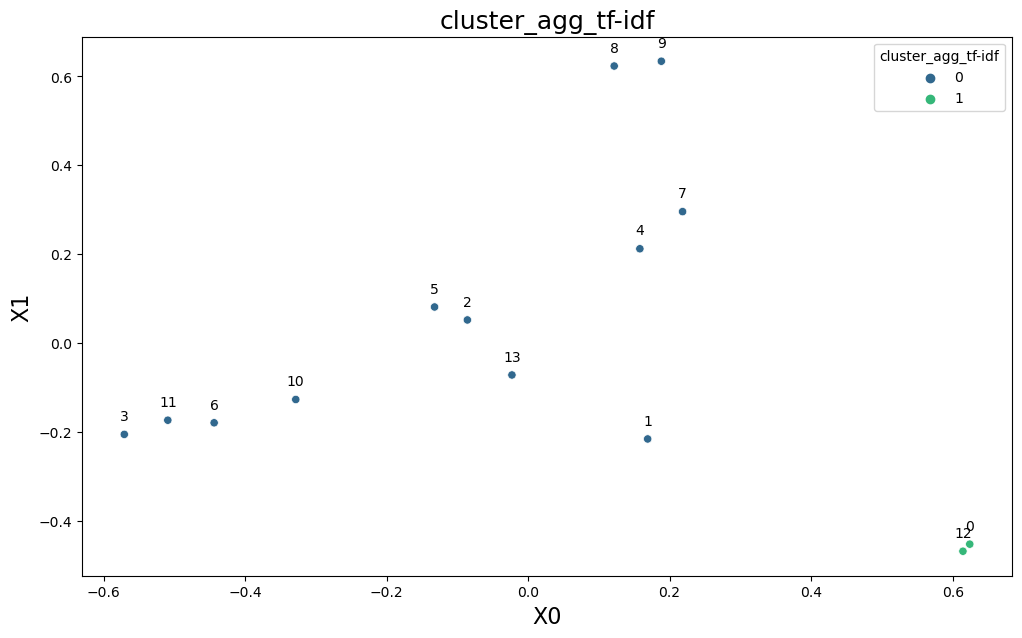

Group 0:
The apparatus of claim 1, ftirther comprising a body having a cradle for the handset, wherein the onloff hook switch operates in response to placing the handset in the cradle.

The apparatus of claim 1, 2 or 3, ftirther comprising: call receiving means for receiving a first call from a calling party; call initiating means for entering a call initiation mode, in response to activation of a first predetermined button, for initiating a second call; and transfer means for putting the first call on hold, initiating the second call, and toggling, in response to activation of the first predetermined button, between the first and second calls.

The apparatus of claim 3, wherein the first predetermined button is a redial button.

The apparatus of claim 3 or 4, wherein the transfer means toggles between the first and second calls by putting either the first or the second call on hold.

The apparatus of any one of claims 3 to 5, further comprising means for enabling a phonebook lookup op

C:\Users\danba\anaconda3\envs\pythonProject5\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


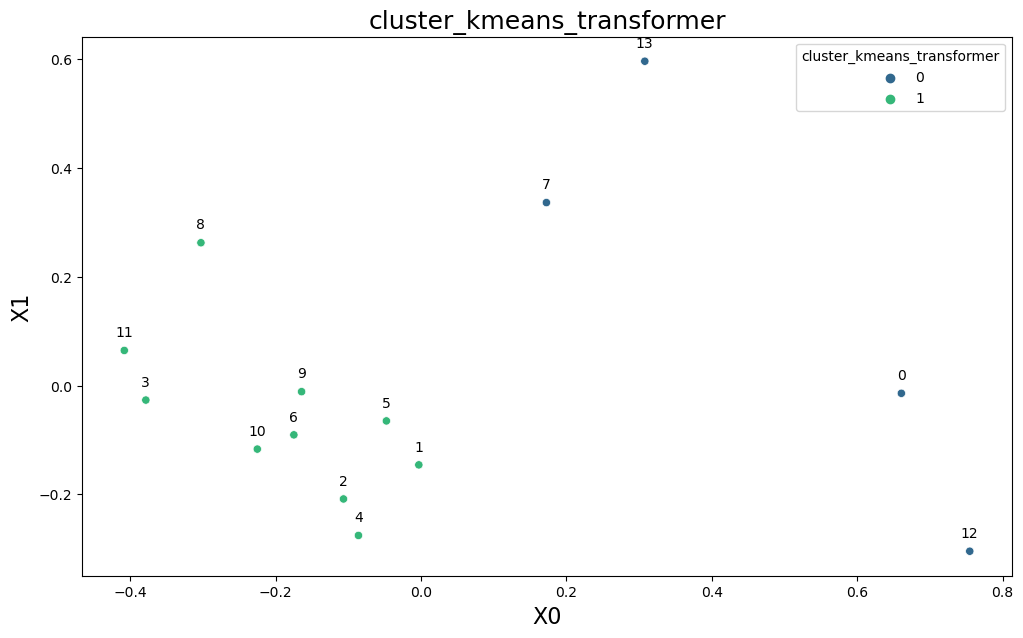

Group 0:
A wireless telephone apparatus comprising: a handset; an onioff-hook switch; a wireless communications module for establishing first and second cellular telephone calls via a base station; and means for generating an explicit call transfer command for sending to the base station in response to activation of the on-hook switch when the first and second wireless calls are established through the apparatus.

The apparatus of any one of the preceding claims, further comprising display means for displaying first and second icons adjacent information relating to the first and second calls respectively, the first and second icons being adapted to switch when toggling between calls.

A method of effecting a call transfer comprising: establishing first and second cellular telephone calls at a wireless telephone apparatus, and generating an explicit call transfer command for sending to a base station in response to activation of an on-hook switch.

A communication apparatus as substanti

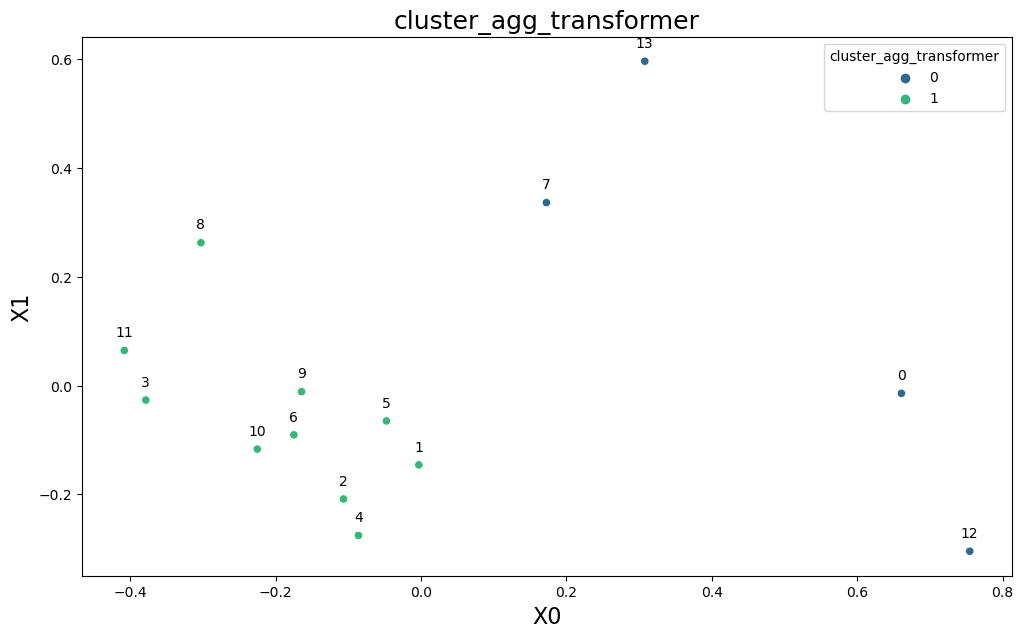

Group 0:
A wireless telephone apparatus comprising: a handset; an onioff-hook switch; a wireless communications module for establishing first and second cellular telephone calls via a base station; and means for generating an explicit call transfer command for sending to the base station in response to activation of the on-hook switch when the first and second wireless calls are established through the apparatus.

The apparatus of any one of the preceding claims, further comprising display means for displaying first and second icons adjacent information relating to the first and second calls respectively, the first and second icons being adapted to switch when toggling between calls.

A method of effecting a call transfer comprising: establishing first and second cellular telephone calls at a wireless telephone apparatus, and generating an explicit call transfer command for sending to a base station in response to activation of an on-hook switch.

A communication apparatus as substanti

C:\Users\danba\anaconda3\envs\pythonProject5\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


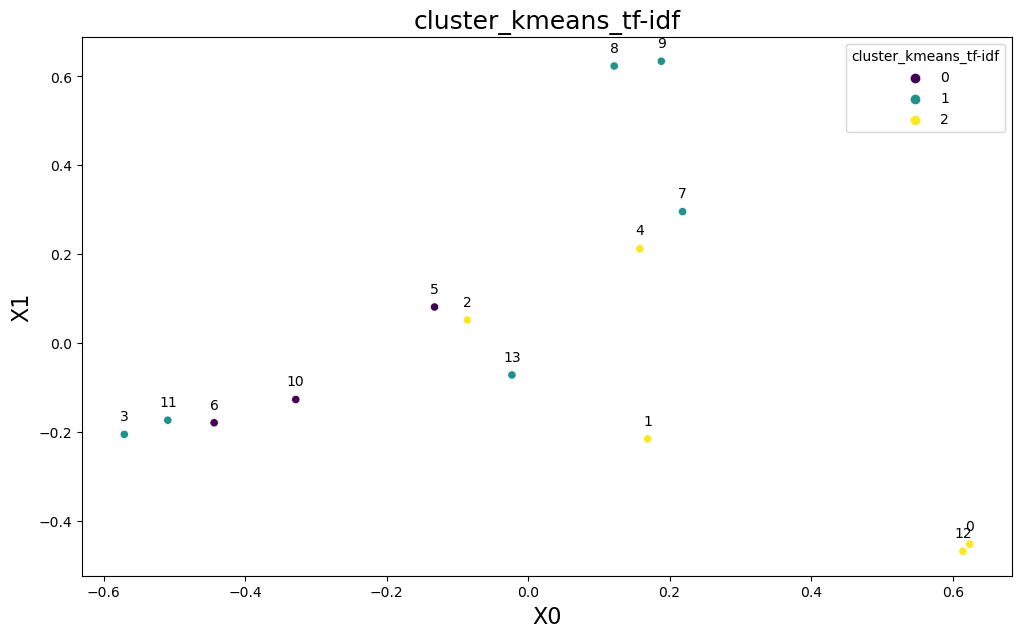

Group 0:
The apparatus of any one of claims 3 to 5, further comprising means for enabling a phonebook lookup operation when in the call initiation mode.

The apparatus of any one of claims 3 to 6, wherein the call initiation mode and a dialling mode are entered using the first predetermined button.

The apparatus of any one of claims 3 to 10, further comprising a second predetermined button which ends an active call and reverts to a call on hold.

Group 1:
The apparatus of claim 3, wherein the first predetermined button is a redial button.

The apparatus of any one of the preceding claims, further comprising display means for displaying first and second icons adjacent information relating to the first and second calls respectively, the first and second icons being adapted to switch when toggling between calls.

The apparatus of claim 8, further comprising selection means for selecting information displayed on the display means.

The apparatus of claim 8 or 9, wherein the transfer means

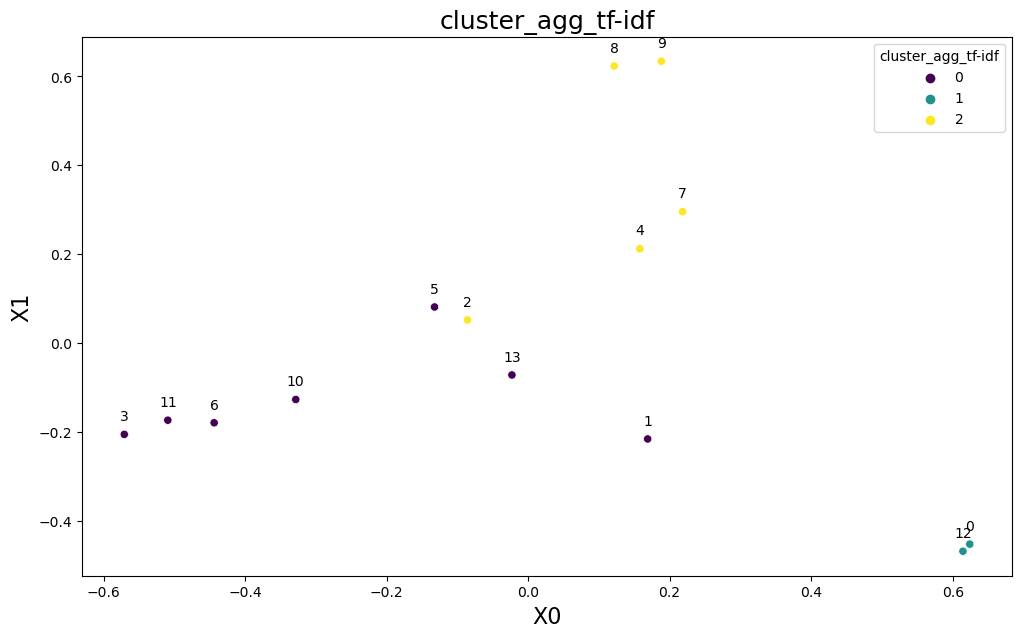

Group 0:
The apparatus of claim 1, ftirther comprising a body having a cradle for the handset, wherein the onloff hook switch operates in response to placing the handset in the cradle.

The apparatus of claim 3, wherein the first predetermined button is a redial button.

The apparatus of any one of claims 3 to 5, further comprising means for enabling a phonebook lookup operation when in the call initiation mode.

The apparatus of any one of claims 3 to 6, wherein the call initiation mode and a dialling mode are entered using the first predetermined button.

The apparatus of any one of claims 3 to 10, further comprising a second predetermined button which ends an active call and reverts to a call on hold.

The apparatus of claim 11, wherein the second predetermined button is a clear button.

A communication apparatus as substantially herein before described with reference to the accompanying drawings in Figures 1 to 7.

Group 1:
A wireless telephone apparatus comprising: a handset; an o

C:\Users\danba\anaconda3\envs\pythonProject5\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


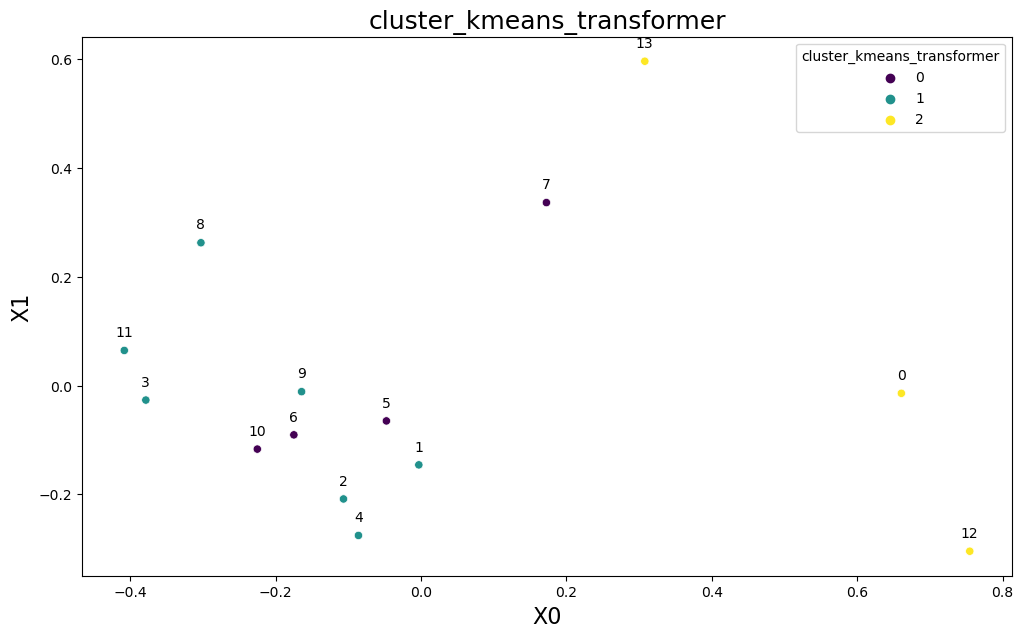

Group 0:
The apparatus of any one of claims 3 to 5, further comprising means for enabling a phonebook lookup operation when in the call initiation mode.

The apparatus of any one of claims 3 to 6, wherein the call initiation mode and a dialling mode are entered using the first predetermined button.

The apparatus of any one of the preceding claims, further comprising display means for displaying first and second icons adjacent information relating to the first and second calls respectively, the first and second icons being adapted to switch when toggling between calls.

The apparatus of any one of claims 3 to 10, further comprising a second predetermined button which ends an active call and reverts to a call on hold.

Group 1:
The apparatus of claim 1, ftirther comprising a body having a cradle for the handset, wherein the onloff hook switch operates in response to placing the handset in the cradle.

The apparatus of claim 1, 2 or 3, ftirther comprising: call receiving means for receiv

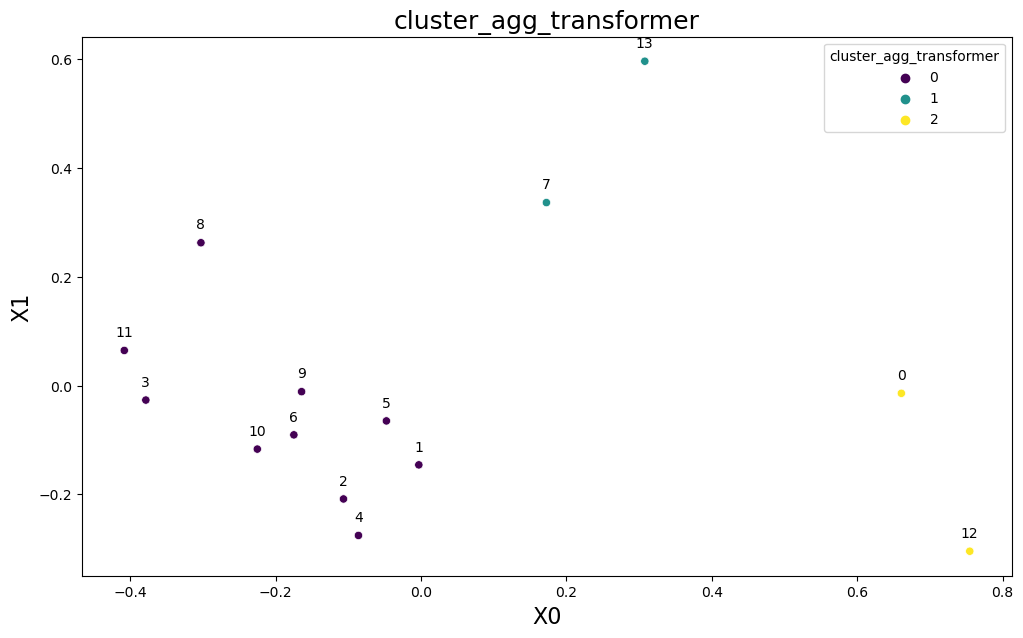

Group 0:
The apparatus of claim 1, ftirther comprising a body having a cradle for the handset, wherein the onloff hook switch operates in response to placing the handset in the cradle.

The apparatus of claim 1, 2 or 3, ftirther comprising: call receiving means for receiving a first call from a calling party; call initiating means for entering a call initiation mode, in response to activation of a first predetermined button, for initiating a second call; and transfer means for putting the first call on hold, initiating the second call, and toggling, in response to activation of the first predetermined button, between the first and second calls.

The apparatus of claim 3, wherein the first predetermined button is a redial button.

The apparatus of claim 3 or 4, wherein the transfer means toggles between the first and second calls by putting either the first or the second call on hold.

The apparatus of any one of claims 3 to 5, further comprising means for enabling a phonebook lookup op

C:\Users\danba\anaconda3\envs\pythonProject5\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


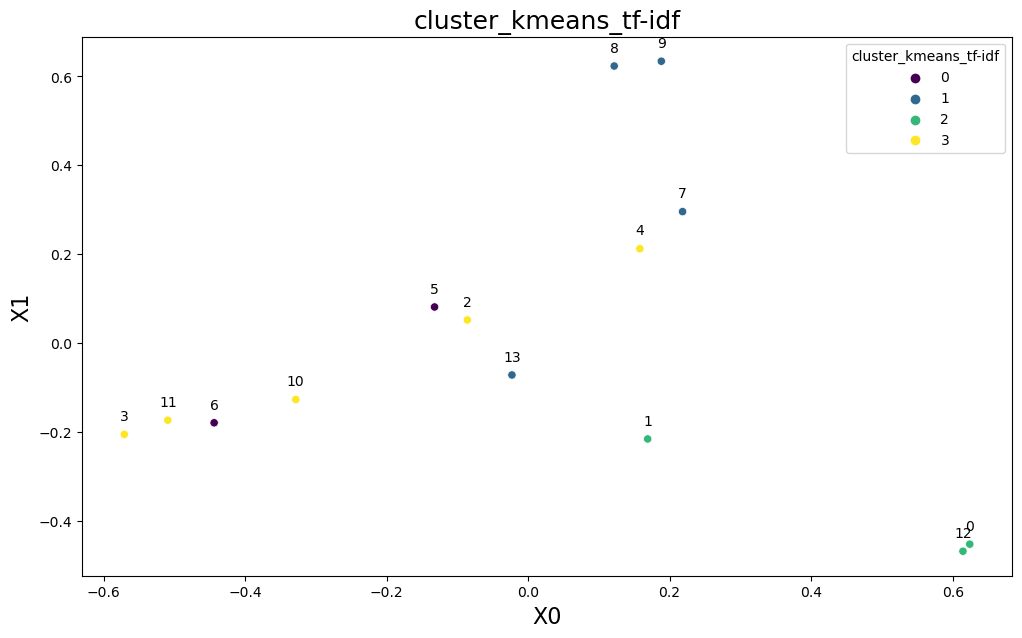

Group 0:
The apparatus of any one of claims 3 to 5, further comprising means for enabling a phonebook lookup operation when in the call initiation mode.

The apparatus of any one of claims 3 to 6, wherein the call initiation mode and a dialling mode are entered using the first predetermined button.

Group 1:
The apparatus of any one of the preceding claims, further comprising display means for displaying first and second icons adjacent information relating to the first and second calls respectively, the first and second icons being adapted to switch when toggling between calls.

The apparatus of claim 8, further comprising selection means for selecting information displayed on the display means.

The apparatus of claim 8 or 9, wherein the transfer means is adapted to initiate a call to a second party whose information is displayed on the display means.

A communication apparatus as substantially herein before described with reference to the accompanying drawings in Figures 1 to 7.

Gro

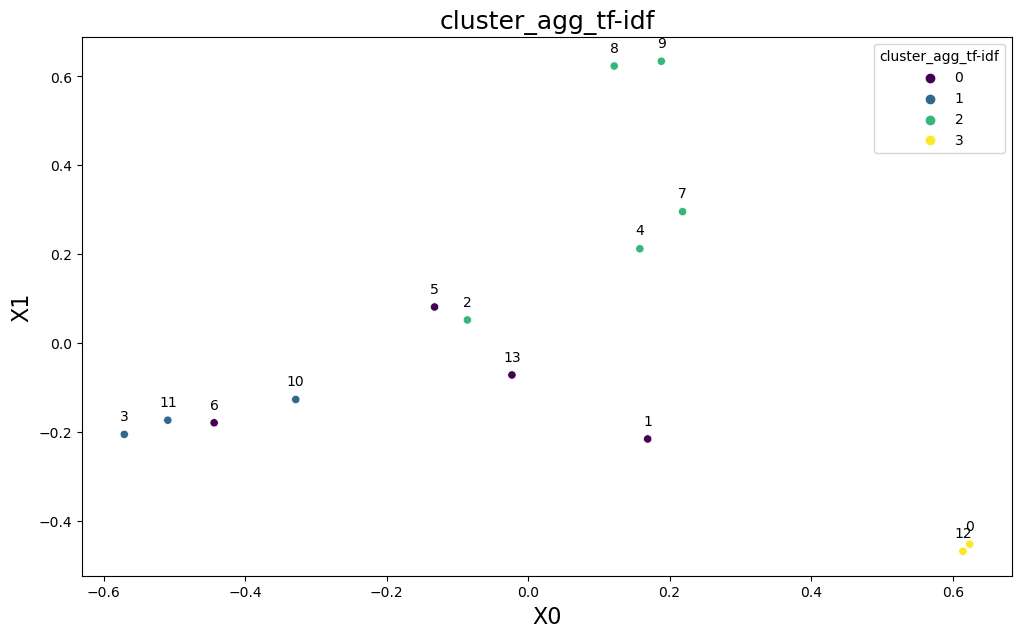

Group 0:
The apparatus of claim 1, ftirther comprising a body having a cradle for the handset, wherein the onloff hook switch operates in response to placing the handset in the cradle.

The apparatus of any one of claims 3 to 5, further comprising means for enabling a phonebook lookup operation when in the call initiation mode.

The apparatus of any one of claims 3 to 6, wherein the call initiation mode and a dialling mode are entered using the first predetermined button.

A communication apparatus as substantially herein before described with reference to the accompanying drawings in Figures 1 to 7.

Group 1:
The apparatus of claim 3, wherein the first predetermined button is a redial button.

The apparatus of any one of claims 3 to 10, further comprising a second predetermined button which ends an active call and reverts to a call on hold.

The apparatus of claim 11, wherein the second predetermined button is a clear button.

Group 2:
The apparatus of claim 1, 2 or 3, ftirther compri

C:\Users\danba\anaconda3\envs\pythonProject5\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


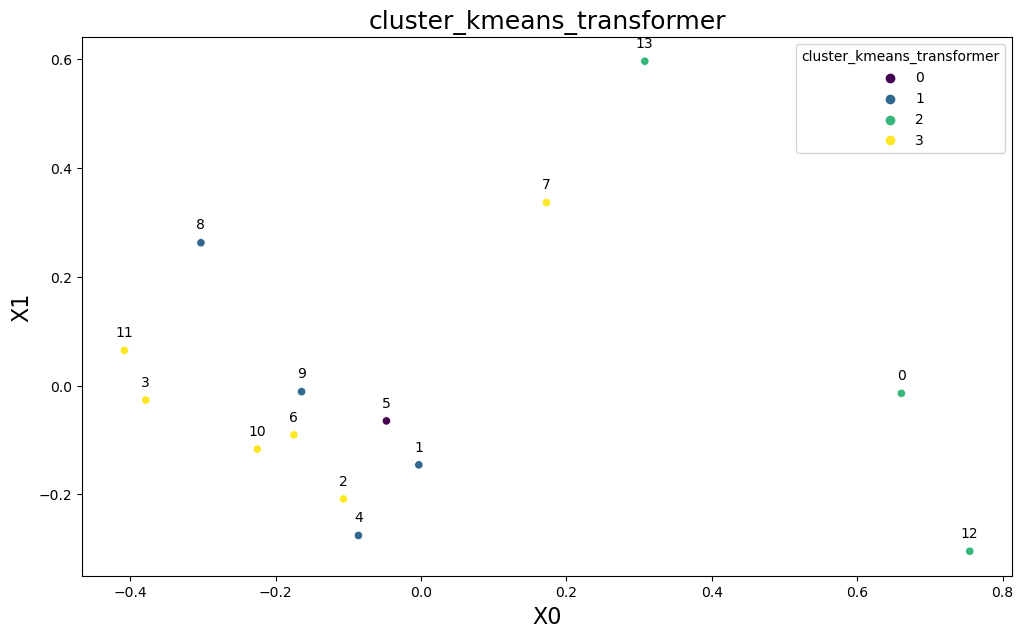

Group 0:
The apparatus of any one of claims 3 to 5, further comprising means for enabling a phonebook lookup operation when in the call initiation mode.

Group 1:
The apparatus of claim 1, ftirther comprising a body having a cradle for the handset, wherein the onloff hook switch operates in response to placing the handset in the cradle.

The apparatus of claim 3 or 4, wherein the transfer means toggles between the first and second calls by putting either the first or the second call on hold.

The apparatus of claim 8, further comprising selection means for selecting information displayed on the display means.

The apparatus of claim 8 or 9, wherein the transfer means is adapted to initiate a call to a second party whose information is displayed on the display means.

Group 2:
A wireless telephone apparatus comprising: a handset; an onioff-hook switch; a wireless communications module for establishing first and second cellular telephone calls via a base station; and means for generating

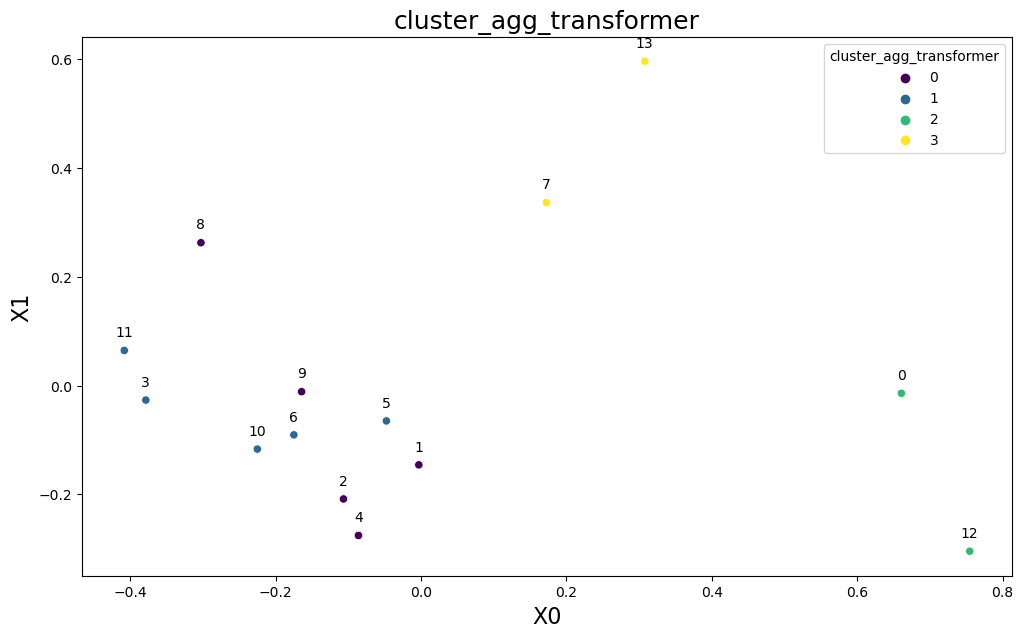

Group 0:
The apparatus of claim 1, ftirther comprising a body having a cradle for the handset, wherein the onloff hook switch operates in response to placing the handset in the cradle.

The apparatus of claim 1, 2 or 3, ftirther comprising: call receiving means for receiving a first call from a calling party; call initiating means for entering a call initiation mode, in response to activation of a first predetermined button, for initiating a second call; and transfer means for putting the first call on hold, initiating the second call, and toggling, in response to activation of the first predetermined button, between the first and second calls.

The apparatus of claim 3 or 4, wherein the transfer means toggles between the first and second calls by putting either the first or the second call on hold.

The apparatus of claim 8, further comprising selection means for selecting information displayed on the display means.

The apparatus of claim 8 or 9, wherein the transfer means is adapted

C:\Users\danba\anaconda3\envs\pythonProject5\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


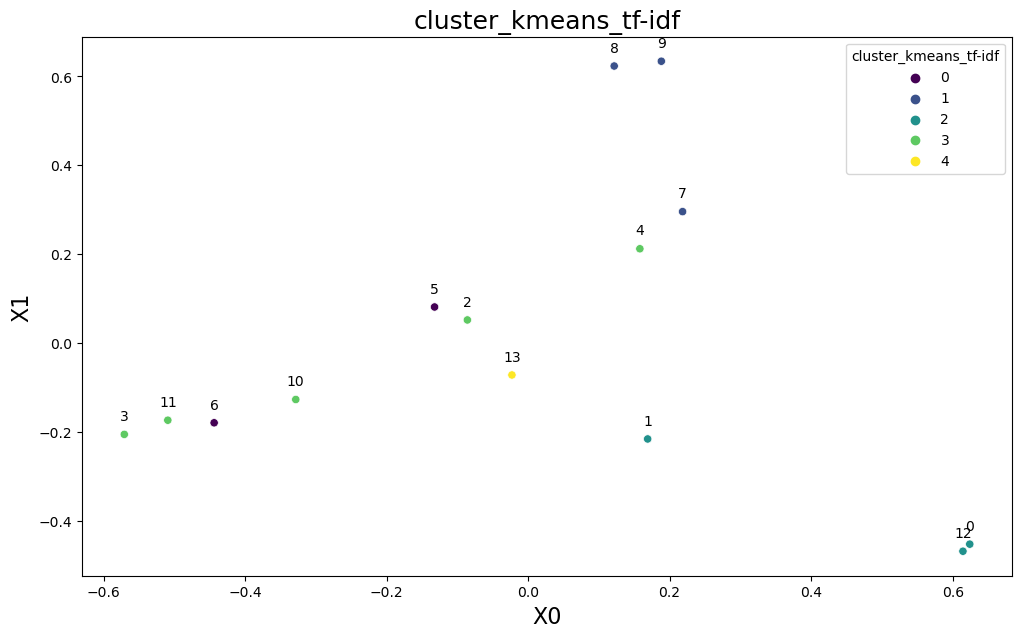

Group 0:
The apparatus of any one of claims 3 to 5, further comprising means for enabling a phonebook lookup operation when in the call initiation mode.

The apparatus of any one of claims 3 to 6, wherein the call initiation mode and a dialling mode are entered using the first predetermined button.

Group 1:
The apparatus of any one of the preceding claims, further comprising display means for displaying first and second icons adjacent information relating to the first and second calls respectively, the first and second icons being adapted to switch when toggling between calls.

The apparatus of claim 8, further comprising selection means for selecting information displayed on the display means.

The apparatus of claim 8 or 9, wherein the transfer means is adapted to initiate a call to a second party whose information is displayed on the display means.

Group 2:
A wireless telephone apparatus comprising: a handset; an onioff-hook switch; a wireless communications module for establishin

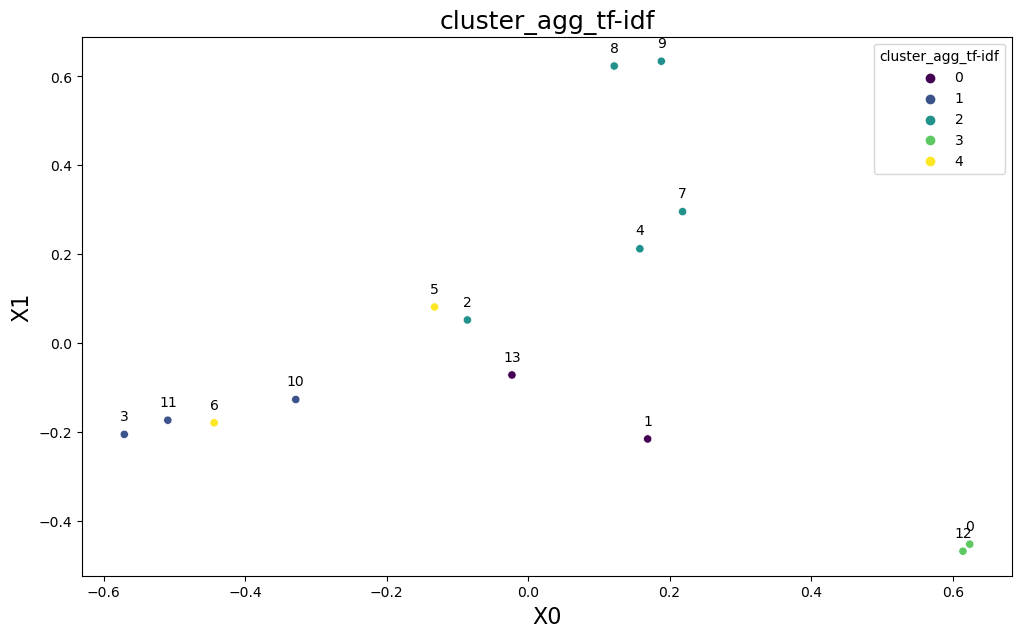

Group 0:
The apparatus of claim 1, ftirther comprising a body having a cradle for the handset, wherein the onloff hook switch operates in response to placing the handset in the cradle.

A communication apparatus as substantially herein before described with reference to the accompanying drawings in Figures 1 to 7.

Group 1:
The apparatus of claim 3, wherein the first predetermined button is a redial button.

The apparatus of any one of claims 3 to 10, further comprising a second predetermined button which ends an active call and reverts to a call on hold.

The apparatus of claim 11, wherein the second predetermined button is a clear button.

Group 2:
The apparatus of claim 1, 2 or 3, ftirther comprising: call receiving means for receiving a first call from a calling party; call initiating means for entering a call initiation mode, in response to activation of a first predetermined button, for initiating a second call; and transfer means for putting the first call on hold, initiating th

C:\Users\danba\anaconda3\envs\pythonProject5\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


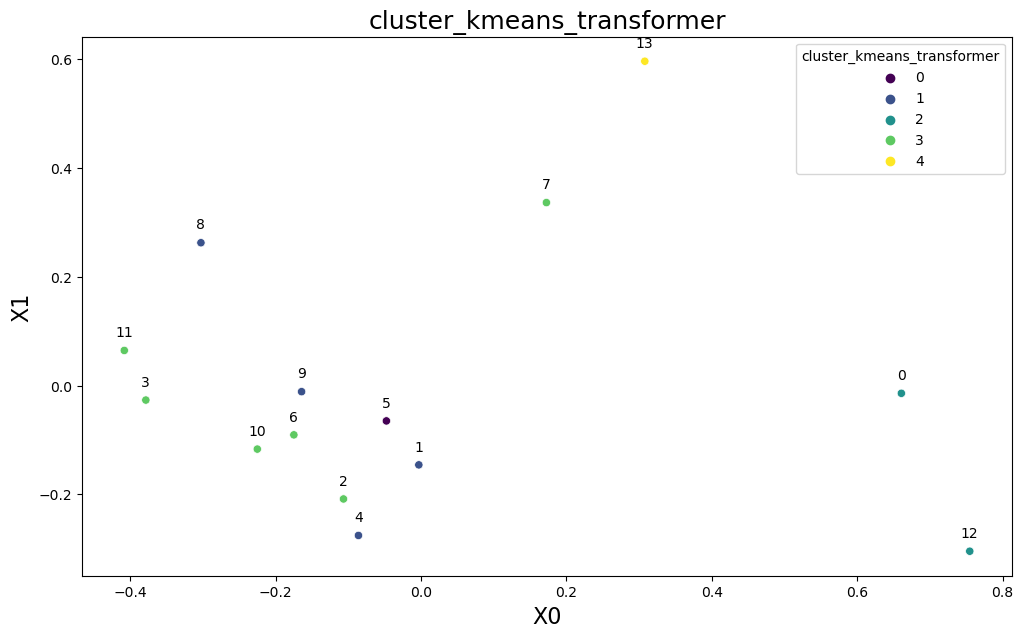

Group 0:
The apparatus of any one of claims 3 to 5, further comprising means for enabling a phonebook lookup operation when in the call initiation mode.

Group 1:
The apparatus of claim 1, ftirther comprising a body having a cradle for the handset, wherein the onloff hook switch operates in response to placing the handset in the cradle.

The apparatus of claim 3 or 4, wherein the transfer means toggles between the first and second calls by putting either the first or the second call on hold.

The apparatus of claim 8, further comprising selection means for selecting information displayed on the display means.

The apparatus of claim 8 or 9, wherein the transfer means is adapted to initiate a call to a second party whose information is displayed on the display means.

Group 2:
A wireless telephone apparatus comprising: a handset; an onioff-hook switch; a wireless communications module for establishing first and second cellular telephone calls via a base station; and means for generating

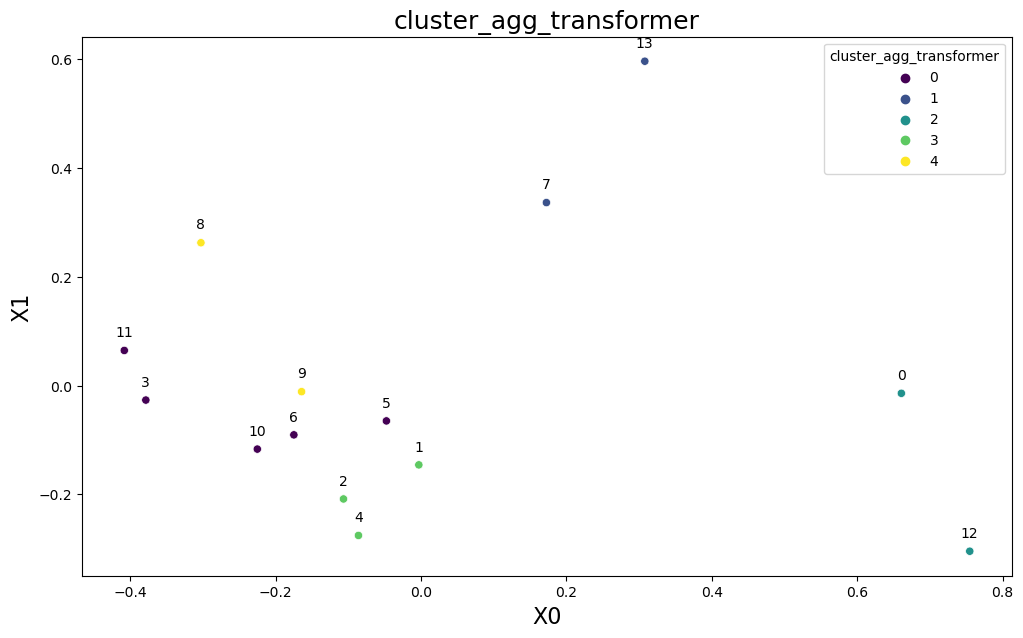

Group 0:
The apparatus of claim 3, wherein the first predetermined button is a redial button.

The apparatus of any one of claims 3 to 5, further comprising means for enabling a phonebook lookup operation when in the call initiation mode.

The apparatus of any one of claims 3 to 6, wherein the call initiation mode and a dialling mode are entered using the first predetermined button.

The apparatus of any one of claims 3 to 10, further comprising a second predetermined button which ends an active call and reverts to a call on hold.

The apparatus of claim 11, wherein the second predetermined button is a clear button.

Group 1:
The apparatus of any one of the preceding claims, further comprising display means for displaying first and second icons adjacent information relating to the first and second calls respectively, the first and second icons being adapted to switch when toggling between calls.

A communication apparatus as substantially herein before described with reference to the a

C:\Users\danba\anaconda3\envs\pythonProject5\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


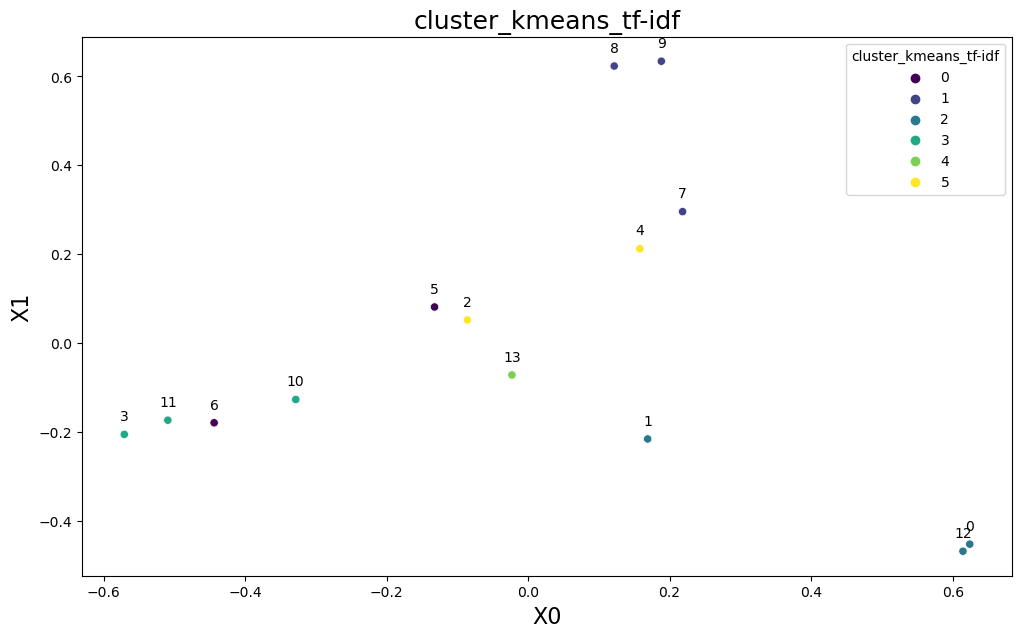

Group 0:
The apparatus of any one of claims 3 to 5, further comprising means for enabling a phonebook lookup operation when in the call initiation mode.

The apparatus of any one of claims 3 to 6, wherein the call initiation mode and a dialling mode are entered using the first predetermined button.

Group 1:
The apparatus of any one of the preceding claims, further comprising display means for displaying first and second icons adjacent information relating to the first and second calls respectively, the first and second icons being adapted to switch when toggling between calls.

The apparatus of claim 8, further comprising selection means for selecting information displayed on the display means.

The apparatus of claim 8 or 9, wherein the transfer means is adapted to initiate a call to a second party whose information is displayed on the display means.

Group 2:
A wireless telephone apparatus comprising: a handset; an onioff-hook switch; a wireless communications module for establishin

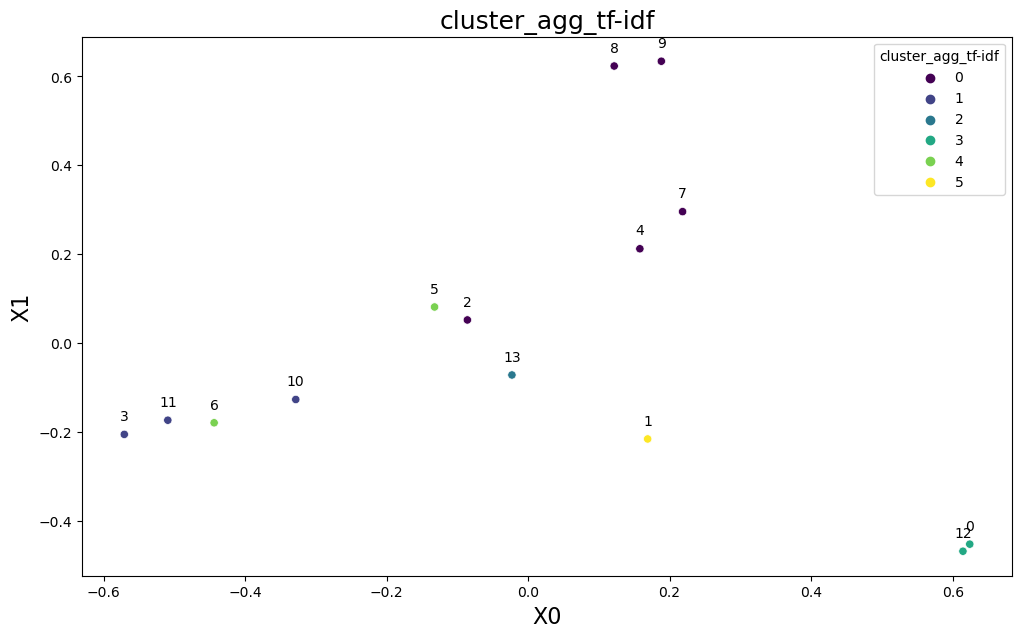

Group 0:
The apparatus of claim 1, 2 or 3, ftirther comprising: call receiving means for receiving a first call from a calling party; call initiating means for entering a call initiation mode, in response to activation of a first predetermined button, for initiating a second call; and transfer means for putting the first call on hold, initiating the second call, and toggling, in response to activation of the first predetermined button, between the first and second calls.

The apparatus of claim 3 or 4, wherein the transfer means toggles between the first and second calls by putting either the first or the second call on hold.

The apparatus of any one of the preceding claims, further comprising display means for displaying first and second icons adjacent information relating to the first and second calls respectively, the first and second icons being adapted to switch when toggling between calls.

The apparatus of claim 8, further comprising selection means for selecting information di

C:\Users\danba\anaconda3\envs\pythonProject5\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


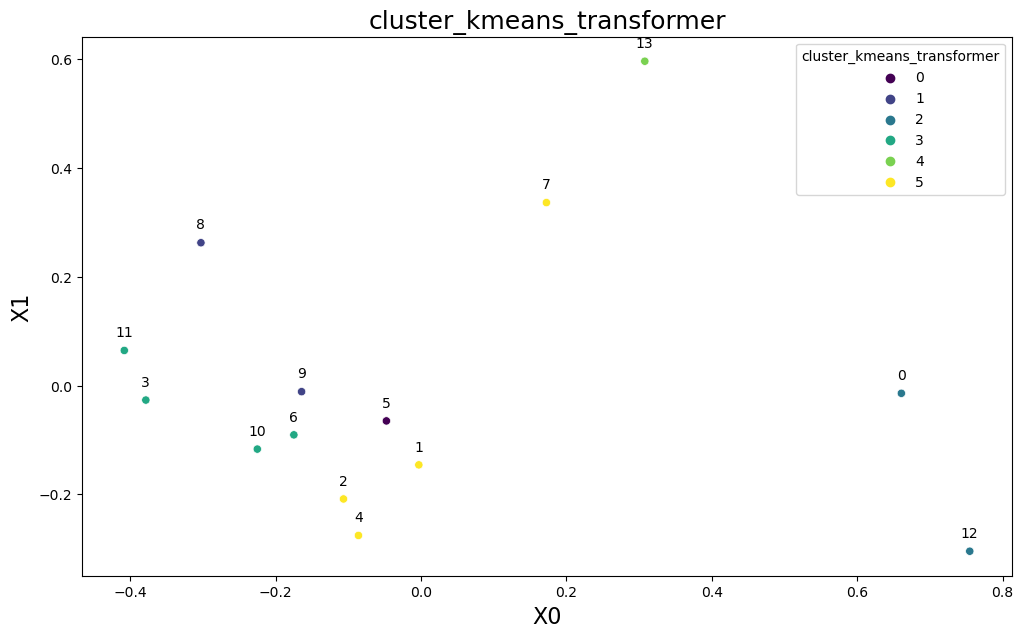

Group 0:
The apparatus of any one of claims 3 to 5, further comprising means for enabling a phonebook lookup operation when in the call initiation mode.

Group 1:
The apparatus of claim 8, further comprising selection means for selecting information displayed on the display means.

The apparatus of claim 8 or 9, wherein the transfer means is adapted to initiate a call to a second party whose information is displayed on the display means.

Group 2:
A wireless telephone apparatus comprising: a handset; an onioff-hook switch; a wireless communications module for establishing first and second cellular telephone calls via a base station; and means for generating an explicit call transfer command for sending to the base station in response to activation of the on-hook switch when the first and second wireless calls are established through the apparatus.

A method of effecting a call transfer comprising: establishing first and second cellular telephone calls at a wireless telephone apparatus,

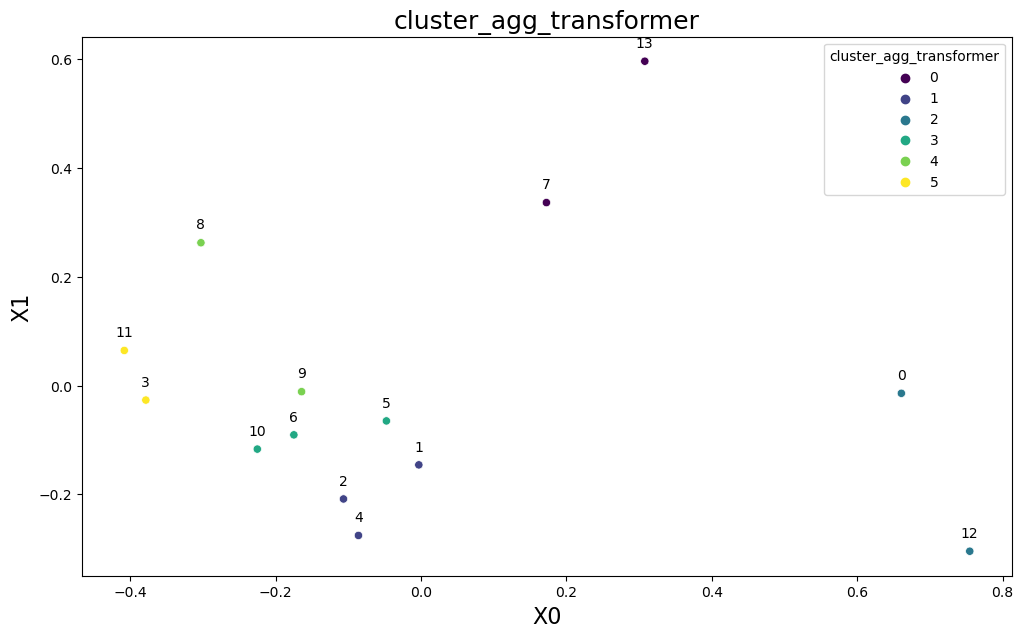

Group 0:
The apparatus of any one of the preceding claims, further comprising display means for displaying first and second icons adjacent information relating to the first and second calls respectively, the first and second icons being adapted to switch when toggling between calls.

A communication apparatus as substantially herein before described with reference to the accompanying drawings in Figures 1 to 7.

Group 1:
The apparatus of claim 1, ftirther comprising a body having a cradle for the handset, wherein the onloff hook switch operates in response to placing the handset in the cradle.

The apparatus of claim 1, 2 or 3, ftirther comprising: call receiving means for receiving a first call from a calling party; call initiating means for entering a call initiation mode, in response to activation of a first predetermined button, for initiating a second call; and transfer means for putting the first call on hold, initiating the second call, and toggling, in response to activation of

In [770]:
from sklearn.cluster import AgglomerativeClustering
for k in range(2, 6):
    num_clusters = k
    for embedding_and_method in [(features_tfidf, 'TF-IDF'), (features_transformers, 'Transformer')]:
        embedding, method = embedding_and_method[0], embedding_and_method[1]
        
        for cluster_method in ['kmeans', 'agg']:
            if cluster_method == 'kmeans':
                kmeans = KMeans(n_clusters=num_clusters, random_state=42)
                kmeans.fit(embedding)
                clusters = kmeans.labels_
            else:
                agg = AgglomerativeClustering(n_clusters=num_clusters)
                agg.fit(embedding)
                clusters = agg.labels_
                
            method = method.lower()
            clusters_result_name = f'cluster_{cluster_method}_{method}'
            df[clusters_result_name] = clusters

            grouped_df = df.groupby(clusters_result_name)['Strings'].apply(lambda x: '\n'.join(x)).reset_index()
                    
            
            eval_cluster(clusters_result_name, f'encode_{method}', num_clusters)
            
            dimension_reduction(embedding, method)
            
            plot_pca(f'x0_{method}', f'x1_{method}', cluster_name=clusters_result_name)
            
            #give each group a title and print it
            grouped_df = df.groupby(clusters_result_name)['Strings'].apply(lambda x: '\n'.join(x)).reset_index()
            for index, row in grouped_df.iterrows():
                print(f"Group {row[clusters_result_name]}:")
                for string in row['Strings'].split('\n'):
                    print(string)
                    print()

I will also measure the time it takes each model to make an inference as one of these models will be used in the final product.

In [771]:
import time
sample_to_time = "https://patents.google.com/patent/US9634864B2/en?oq=US9634864B2"
claims = []
soup = moveoHLS_task.get_soup_from_url(site)
moveoHLS_task.extract_claim_texts(soup, claims)
df_time = pd.DataFrame(claims, columns=['Strings'])

start_time = time.time()
model = SentenceTransformer('all-MiniLM-L6-v2')
df_time['encode_transformer'] = df_time['Strings'].apply(lambda text: model.encode(text, convert_to_numpy=True).flatten())
features_transformers = np.vstack(df_time['encode_transformer'])

agg = AgglomerativeClustering(n_clusters=3)
agg.fit(features_transformers)
# End time measurement
end_time = time.time()
elapsed_time = end_time - start_time
print("Time for transformer model:", elapsed_time, "seconds")

start_time = time.time()
documents = df_time['Strings'].values.astype("U")
vectorizer = TfidfVectorizer(stop_words='english')
features_tfidf = vectorizer.fit_transform(documents).toarray()

agg = AgglomerativeClustering(n_clusters=3)
agg.fit(features_transformers)
# End time measurement
end_time = time.time()
elapsed_time = end_time - start_time
print("Time for tf-idf model:", elapsed_time, "seconds")

Total claims found: 14
All claim texts extracted successfully.


C:\Users\danba\anaconda3\envs\pythonProject5\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Time for transformer model: 1.8157424926757812 seconds
Time for tf-idf model: 0.0031392574310302734 seconds


As expected the transformer model took more time to make an inference than the tf-idf model because the vector space is higher dimensional in the transformer, 83 vs 384, which makes the fit process after encoding longer. 

I decided that the transformer model, which uses hierarchical clustering, will serve as the backend of my application in Task 3.
It made fairly reasonable clusters (k=3 in the example we ran above) compared to TF-IDF. It seems like the learned mapping of words to the vector space of the trained encoder transformer gives better results than the TF-IDF formula.

Moreover, what makes the time difference is the clustering stage, as we need to compute it in fairly high dimension (384). But compared to other pretrained encoders like BERT (768) and GloVe (1000), it is much faster.

One common practice to reduce inference time is make PCA, reduce the dimension after encoding (hopefully don't lose important information) and only then run the clustering method.
